In [34]:
import math

import torch
import gpytorch

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def filterinitialset (filename, headername = "vibrational level v\Temperature(K)",  \
    factor = 1.0, normalize = False):

    dfin = pd.read_excel(filename)

    #print(dfin)
    
    dfdict = {}
    
    tempvalues = list(dfin.columns[1:])
    vibvalues = list(dfin[headername].values)

    min = float("inf")
    max = float("-inf")
    for c in dfin.columns:
        dfdict[c] = []
        if c == headername:
            dfdict[c] = list(dfin[c].values)
        else:
            for v in dfin[c].values:
                val = factor*v
                if val > max:
                    max = val
                if val < min:
                    min = val

    for c in dfin.columns:
        if c != headername:
            for v in dfin[c].values:
                val = factor*v
                valp = (val - min) / (max - min)
                if normalize:
                    dfdict[c].append(valp)
                else:
                    dfdict[c].append(val)

    df = pd.DataFrame.from_dict(dfdict)

    return df, vibvalues, tempvalues

##############################################################################

def plotfull3dcurve (df, vib_values, temp_values):

    y = []
    x = []
    for t in temp_values:
        for idx in range(len(vib_values)):
            x.append([float(t), float(vib_values[idx])])
            y.append(df[t].values[idx])

    X = np.array(x)
    Y = np.array(y)

    xdim = len(temp_values)
    ydim = len(vib_values)

    Xp = np.zeros((xdim, ydim), dtype=float)
    Yp = np.zeros((xdim, ydim), dtype=float)
    Zp = np.zeros((xdim, ydim), dtype=float)
    for xidx in range(xdim):
        t = temp_values[xidx]
        for yidx in range(ydim):
            v =  vib_values[yidx]
            Xp[xidx, yidx] = float(t)
            Yp[xidx, yidx] = float(v)
            Zp[xidx, yidx] = df[t].values[yidx]

    #fig = plt.figure(figsize=(10,8))
    fig = plt.figure(figsize=plt.figaspect(2.))
    plt.gcf().set_size_inches(40, 30)
    ax = fig.add_subplot(2,1,1, projection='3d')
    surf = ax.plot_surface(Xp, Yp, Zp, rstride=1, cstride=1, cmap='jet', linewidth=0, antialiased=False)
    plt.show()

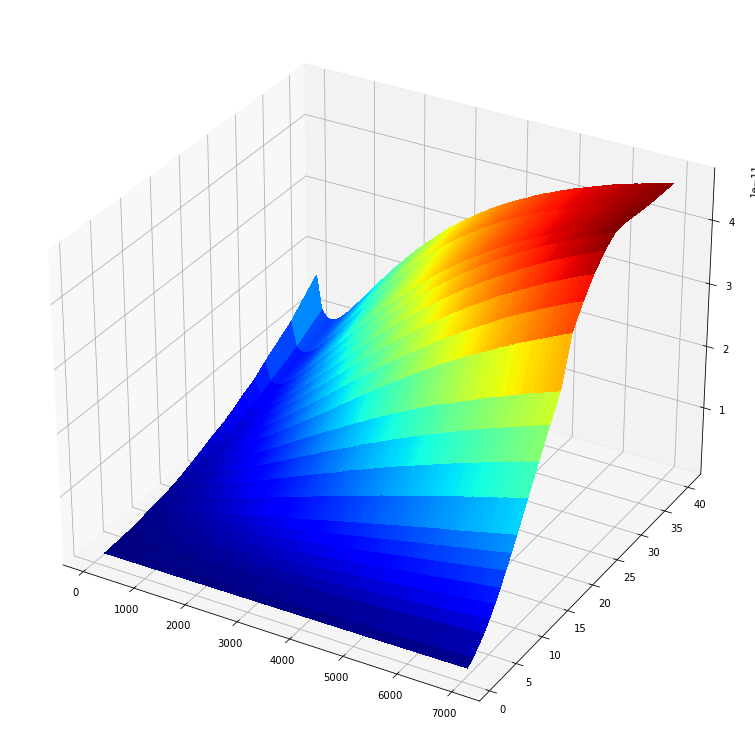

In [36]:
filename = "N2N2_dataset.xls"
df, vib_values , temp_values = filterinitialset (filename)
plotfull3dcurve (df, vib_values, temp_values)

train_x = torch.linspace(0, 1, len(vib_values), dtype=torch.float64)
train_y = torch.linspace(0, 1, len(vib_values), dtype=torch.float64)



Xval range:  tensor(1., dtype=torch.float64) tensor(40., dtype=torch.float64)
Yval range:  tensor(-30.7433, dtype=torch.float64) tensor(-24.8967, dtype=torch.float64)


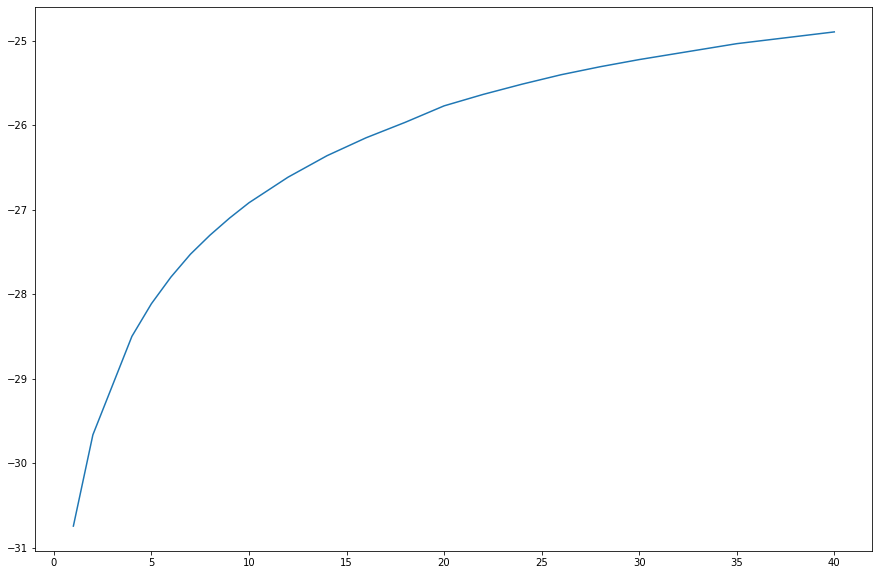

In [37]:
selectedtemp = temp_values[10]

for idx in range(len(vib_values)):
    train_x[idx] = vib_values[idx]
    
    yval = df[selectedtemp].values[idx]
    #usinh log sdcale
    yval = math.log(yval)
    train_y[idx] = yval

minx = torch.min(train_x)
maxx = torch.max(train_x)
print("Xval range: ", minx, maxx)

miny = torch.min(train_y)
maxy = torch.max(train_y)
print("Yval range: ", miny, maxy)

plt.plot(train_x.numpy(), train_y.numpy())
plt.gcf().set_size_inches(15, 10)
plt.show()

In [38]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [39]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 5000


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/5000 - Loss: 231.692   lengthscale: 0.693   noise: 0.693
Iter 2/5000 - Loss: 210.029   lengthscale: 0.744   noise: 0.744
Iter 3/5000 - Loss: 190.405   lengthscale: 0.798   noise: 0.798
Iter 4/5000 - Loss: 172.662   lengthscale: 0.854   noise: 0.853
Iter 5/5000 - Loss: 156.672   lengthscale: 0.913   noise: 0.910
Iter 6/5000 - Loss: 142.329   lengthscale: 0.974   noise: 0.968
Iter 7/5000 - Loss: 129.524   lengthscale: 1.037   noise: 1.027
Iter 8/5000 - Loss: 118.143   lengthscale: 1.102   noise: 1.086
Iter 9/5000 - Loss: 108.062   lengthscale: 1.168   noise: 1.145
Iter 10/5000 - Loss: 99.152   lengthscale: 1.236   noise: 1.204
Iter 11/5000 - Loss: 91.284   lengthscale: 1.304   noise: 1.262
Iter 12/5000 - Loss: 84.334   lengthscale: 1.373   noise: 1.319
Iter 13/5000 - Loss: 78.187   lengthscale: 1.442   noise: 1.375
Iter 14/5000 - Loss: 72.742   lengthscale: 1.512   noise: 1.430
Iter 15/5000 - Loss: 67.906   lengthscale: 1.580   noise: 1.483
Iter 16/5000 - Loss: 63.601   lengthscal

In [40]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(minx, maxx, 150, dtype=torch.float64)
    print("Test points: ", test_x)
    #print(test_x.shape, type(test_x))
    #print(type(model))
    observed_pred = likelihood(model(test_x))

Test points:  tensor([ 1.0000,  1.2617,  1.5235,  1.7852,  2.0470,  2.3087,  2.5705,  2.8322,
         3.0940,  3.3557,  3.6174,  3.8792,  4.1409,  4.4027,  4.6644,  4.9262,
         5.1879,  5.4497,  5.7114,  5.9732,  6.2349,  6.4966,  6.7584,  7.0201,
         7.2819,  7.5436,  7.8054,  8.0671,  8.3289,  8.5906,  8.8523,  9.1141,
         9.3758,  9.6376,  9.8993, 10.1611, 10.4228, 10.6846, 10.9463, 11.2081,
        11.4698, 11.7315, 11.9933, 12.2550, 12.5168, 12.7785, 13.0403, 13.3020,
        13.5638, 13.8255, 14.0872, 14.3490, 14.6107, 14.8725, 15.1342, 15.3960,
        15.6577, 15.9195, 16.1812, 16.4430, 16.7047, 16.9664, 17.2282, 17.4899,
        17.7517, 18.0134, 18.2752, 18.5369, 18.7987, 19.0604, 19.3221, 19.5839,
        19.8456, 20.1074, 20.3691, 20.6309, 20.8926, 21.1544, 21.4161, 21.6779,
        21.9396, 22.2013, 22.4631, 22.7248, 22.9866, 23.2483, 23.5101, 23.7718,
        24.0336, 24.2953, 24.5570, 24.8188, 25.0805, 25.3423, 25.6040, 25.8658,
        26.1275, 26.3893, 

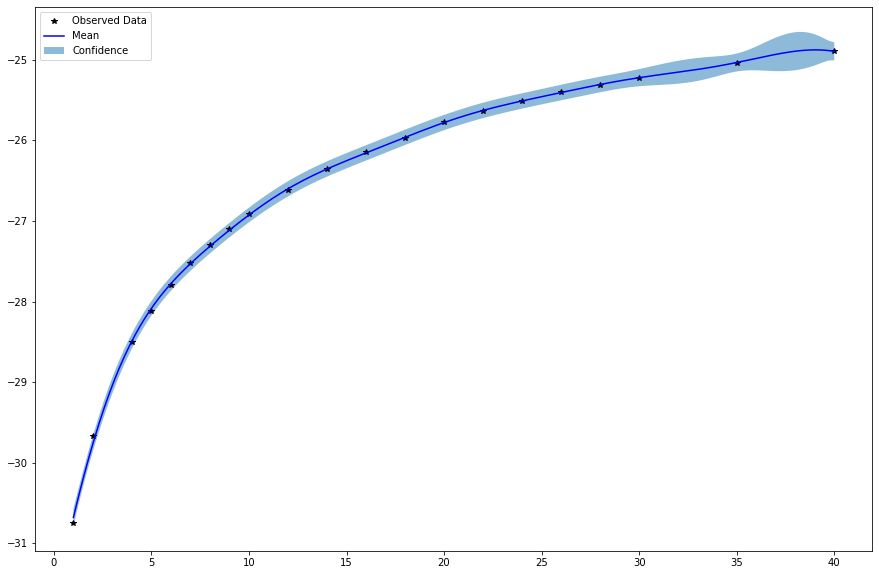

In [41]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
     # ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.gcf().set_size_inches(15, 10)
    plt.show()